# Промышленность

## Описание задачи и данных

**Задача**  
Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.
  
**Описание этапа обработки**  
1. Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.  
2. Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).  
3. Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.  
4. Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).
  
**Описание данных**  
Данные состоят из файлов, полученных из разных источников:
- data_arc.csv — данные об электродах;
- data_bulk.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time.csv — данные о подаче сыпучих материалов (время);
- data_gas.csv — данные о продувке сплава газом;
- data_temp.csv — результаты измерения температуры;
- data_wire.csv — данные о проволочных материалах (объём);
- data_wire_time.csv — данные о проволочных материалах (время).  

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## EDA

Импортируем необходимые библиотеки и выполним загрузку данных.

In [1]:
# установка библиотек
!pip install missingno
!pip install phik

# импорт библиотек и инструментов для обработки данных
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

In [2]:
# загрузка всех файлов в отдельные переменные
data_arc = pd.read_csv('data_arc.csv')
data_bulk = pd.read_csv('data_bulk.csv')
data_bulk_time = pd.read_csv('data_bulk_time.csv')
data_gas = pd.read_csv('data_gas.csv')
data_temp = pd.read_csv('data_temp.csv')
data_wire = pd.read_csv('data_wire.csv')
data_wire_time = pd.read_csv('data_wire_time.csv')

Создадим две функции: одну - для вывода первый 10 строк и основной информации о таблице, вторую - для вывода пропущенных номеров партий.

In [3]:
# функция для вывода первых строк и основной информации
def data_info(data):
    display(data.head(10))
    data.info()
    print('Номера партий:', data['key'].unique())

# функция для вывода пропущенных номеров партий
def passes(data, length):
    pass_list = []
    for i in range(1, length+1):
        if i not in data['key'].unique():
            pass_list.append(i)
    return(pass_list)

Сохраним максимальный номер партии в отдельную переменную для использования в функции passes.

In [4]:
length = 3241

Теперь рассмотрим каждый датафрейм более детально.

### data_arc

In [5]:
# вывод основной информации и пропусков в столбце key
data_info(data_arc)
print('Количество пропущенных партий:', len(passes(data_arc, length)))
print('Список пропущенных партий:', passes(data_arc, length))

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
Номера партий: [   1    2    3 ... 3239 3240 3241]
Количество пропущенных партий: 27
Список пропущенных партий: [41, 42, 195, 279, 355, 382, 506, 529, 540, 607, 683, 710, 766, 1133, 1300, 1437, 2031, 2103, 2278, 2356, 2373, 2446, 2469, 2491, 2683, 3200, 3207]


В таблице нет пропусков, однако отсутствуют данные по некоторым партиям стали.

В столбцах "Начало нагрева дугой" и "Конец нагрева дугой" использованы некорректные типы данных. Приведем данные к типу datetime.

In [6]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

Построим гистограмму распределения количества нагреваний.

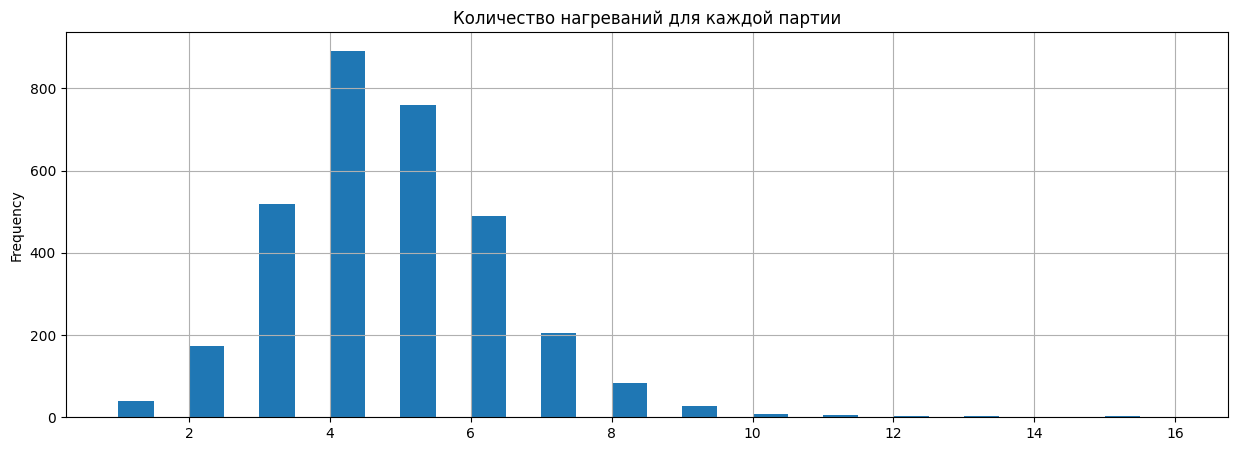

In [7]:
data_arc.groupby('key').count().plot(kind='hist', y='Конец нагрева дугой', figsize=(15, 5), grid=True, legend=False, bins=30, 
                                     title='Количество нагреваний для каждой партии')
plt.show()

Наблюдается нормальное распределения, подавляющее большинство партий нагревается от 1 до 10 раз. Все, что выходит за рамки этих значений, можно считать аномалиями.

Рассмотрим корреляцию между активной и реактивной мощностью.

Коэффициент корреляции между активной и реактивной мощностью: 0.05443724339693738


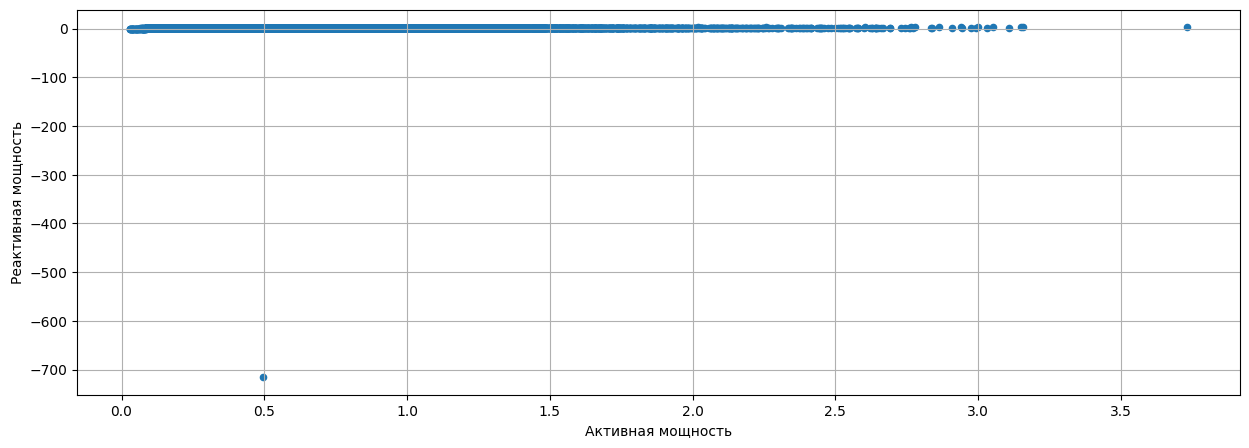

In [8]:
data_arc.plot(x='Активная мощность', y='Реактивная мощность', kind='scatter', grid=True, figsize=(15, 5))
print('Коэффициент корреляции между активной и реактивной мощностью:', 
      data_arc['Активная мощность'].corr(data_arc['Реактивная мощность']))

В данных есть явных выброс: значение реактивной мощности на уровне -700, при том, что все остальные значения распределены в районе 0.

Проверим, сколько в таблице содержится строк со значением реактивной мощности меньше 0.

In [9]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Найдено одно значение, это явный выброс, который нужно удалить.

In [10]:
data_arc = data_arc[data_arc['Реактивная мощность'] >= 0]

Заново рассмотрим корреляцию между двумя столбцами без учета выброса.

Коэффициент корреляции между активной и реактивной мощностью: 0.9631819131519808


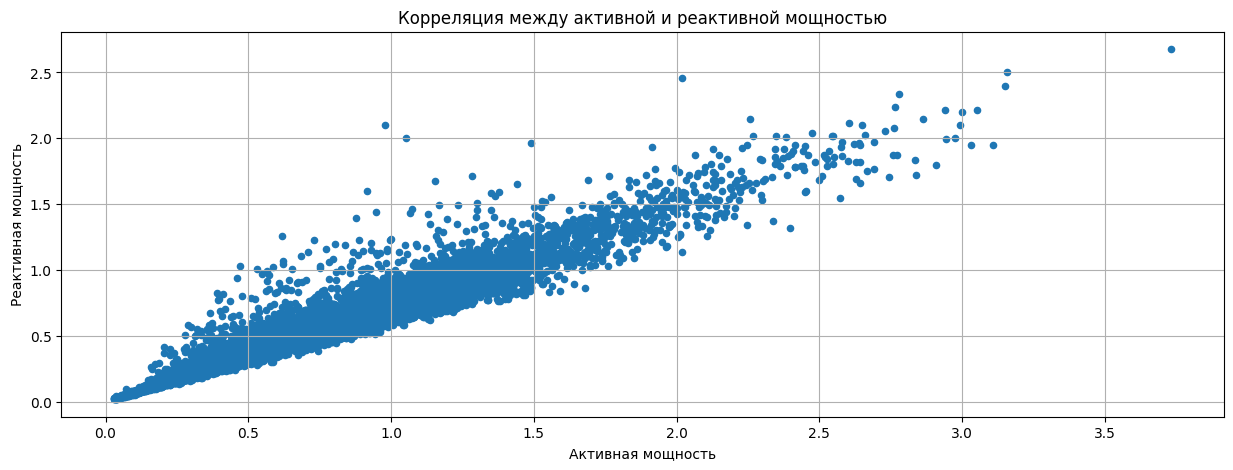

In [11]:
data_arc.plot(x='Активная мощность', y='Реактивная мощность', kind='scatter', grid=True, figsize=(15, 5), 
              title='Корреляция между активной и реактивной мощностью')
print('Коэффициент корреляции между активной и реактивной мощностью:', 
      data_arc['Активная мощность'].corr(data_arc['Реактивная мощность']))

Картина кардинально поменялась. Между активной и реактивной мощностью наблюдается сильная линейная зависимость.

Также рассмотрим распределение значений активной и реактивной мощности.

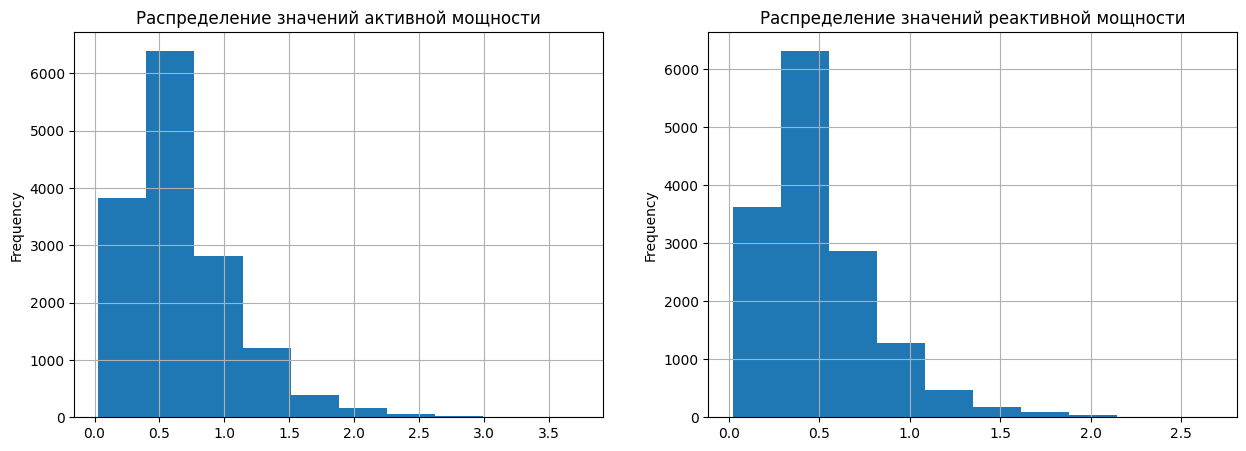

In [12]:
f, axs = plt.subplots(1, 2, figsize=(15, 5))
data_arc['Активная мощность'].plot(kind='hist', ax=axs[0], grid=True, title='Распределение значений активной мощности')
data_arc['Реактивная мощность'].plot(kind='hist', ax=axs[1], grid=True, title='Распределение значений реактивной мощности')
plt.show()

Распределение на двух графиках практически одинаковое, что обусловлено линейной зависимостью между данными.

#### Результаты анализа таблицы data_arc

В таблице нет пропусков, однако отсутствуют данные по некоторым партиям стали.

В столбцах "Начало нагрева дугой" и "Конец нагрева дугой" данные были приведены к корректному типу данных datetime.

Количество нагреваний каждой партии стали распределно нормально, подавляющее большинство партий нагревается от 1 до 10 раз.

Был обнаружен один выброс в значениях реактивной мощности, после удаления которого была выявлена сильная линейная зависимость между активной и реактивной мощностью.

### data_bulk и data_bulk_time

In [13]:
# вывод основной информации и пропусков в столбце key
data_info(data_bulk)
print('Количество пропущенных партий:', len(passes(data_bulk, length)))
print('Список пропущенных партий:', passes(data_bulk, length))

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
Номера партий: [   1    2    3 ... 3239 3240 3241]
Количество пропущенных партий: 112
Список пропущенных партий: [41, 42, 51, 52, 53, 54, 55, 56, 72, 80, 81

In [14]:
# вывод основной информации и пропусков в столбце key
data_info(data_bulk_time)
print('Количество пропущенных партий:', len(passes(data_bulk_time, length)))
print('Список пропущенных партий:', passes(data_bulk_time, length))

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
Номера партий: [   1    2    3 ... 3239 3240 3241]
Количество пропущенных партий: 112
Список пропущенных партий: [41, 42, 51, 52, 53, 54, 55, 56, 72, 80, 81, 110, 151, 188, 1

В данных таблицах много пропущенных значений, также в обеих таблицах отсутствуют данные для одних и тех же партий. Предположительно, пропуски означают то, что примеси на данном этапе не добавлялись.

Визуализируем пропуски в обеих таблицах.

AxesSubplot(0.125,0.11;0.698618x0.77)
AxesSubplot(0.125,0.11;0.698618x0.77)


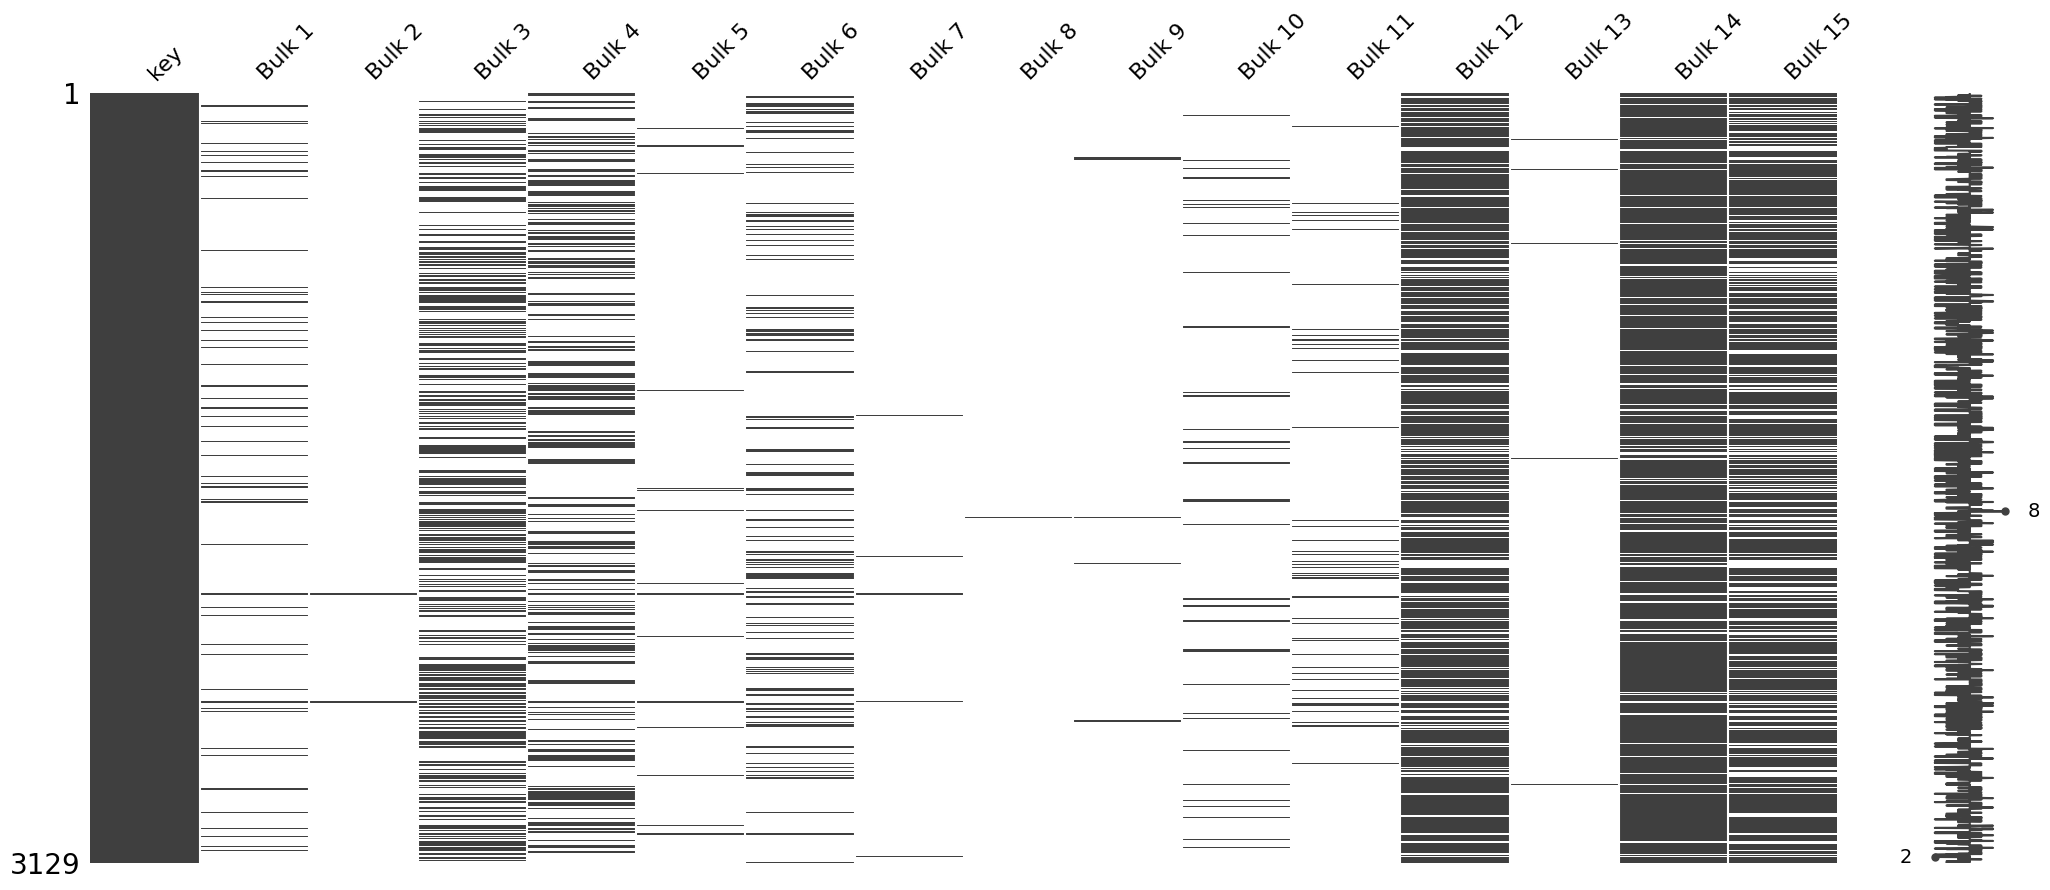

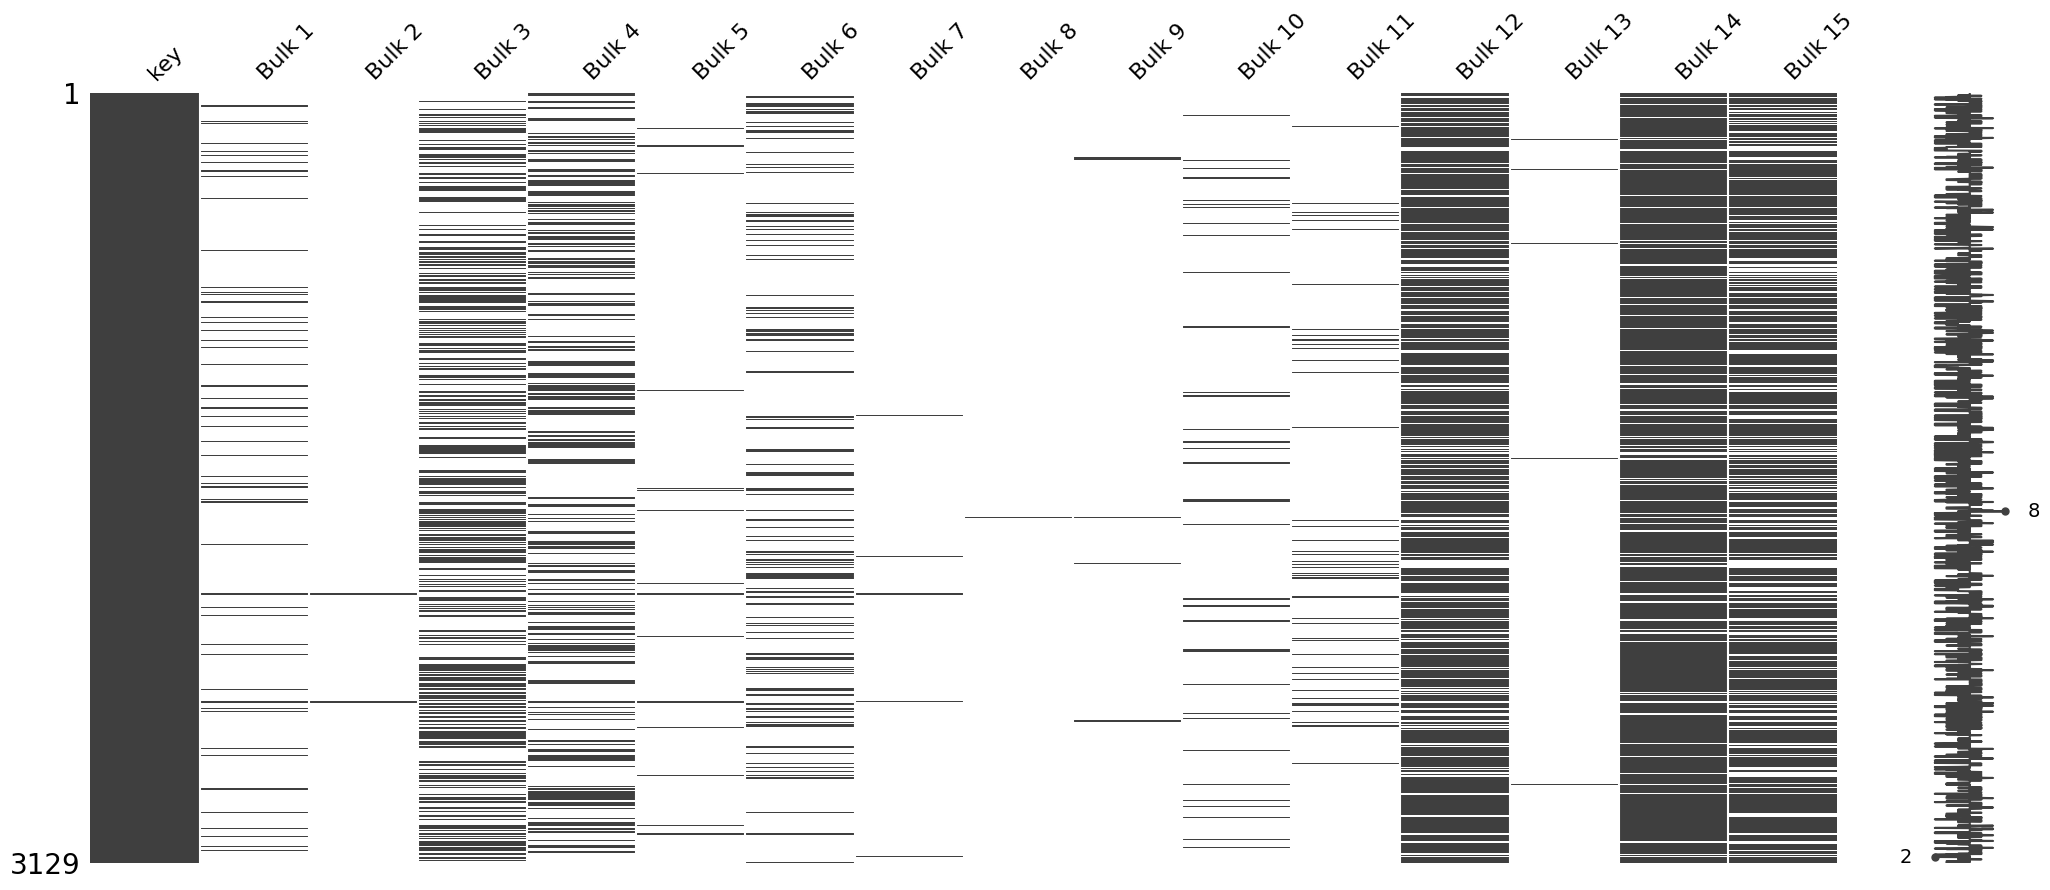

In [15]:
print(msno.matrix(data_bulk))
print(msno.matrix(data_bulk_time))

Графики идентичны, следовательно, пропуски одинаковы для обеих таблиц.

В таблице data_bulk_time использованы некорректные типы данных. Приведем данные к типу datetime.

In [16]:
data_bulk_time['Bulk 1'] = pd.to_datetime(data_bulk_time['Bulk 1'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 2'] = pd.to_datetime(data_bulk_time['Bulk 2'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 3'] = pd.to_datetime(data_bulk_time['Bulk 3'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 4'] = pd.to_datetime(data_bulk_time['Bulk 4'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 5'] = pd.to_datetime(data_bulk_time['Bulk 5'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 6'] = pd.to_datetime(data_bulk_time['Bulk 6'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 7'] = pd.to_datetime(data_bulk_time['Bulk 7'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 8'] = pd.to_datetime(data_bulk_time['Bulk 8'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 9'] = pd.to_datetime(data_bulk_time['Bulk 9'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 10'] = pd.to_datetime(data_bulk_time['Bulk 10'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 11'] = pd.to_datetime(data_bulk_time['Bulk 11'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 12'] = pd.to_datetime(data_bulk_time['Bulk 12'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 13'] = pd.to_datetime(data_bulk_time['Bulk 13'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 14'] = pd.to_datetime(data_bulk_time['Bulk 14'], format='%Y-%m-%d %H:%M:%S')
data_bulk_time['Bulk 15'] = pd.to_datetime(data_bulk_time['Bulk 15'], format='%Y-%m-%d %H:%M:%S')

Построим гистограммы по всем столбцам таблицы data_bulk.

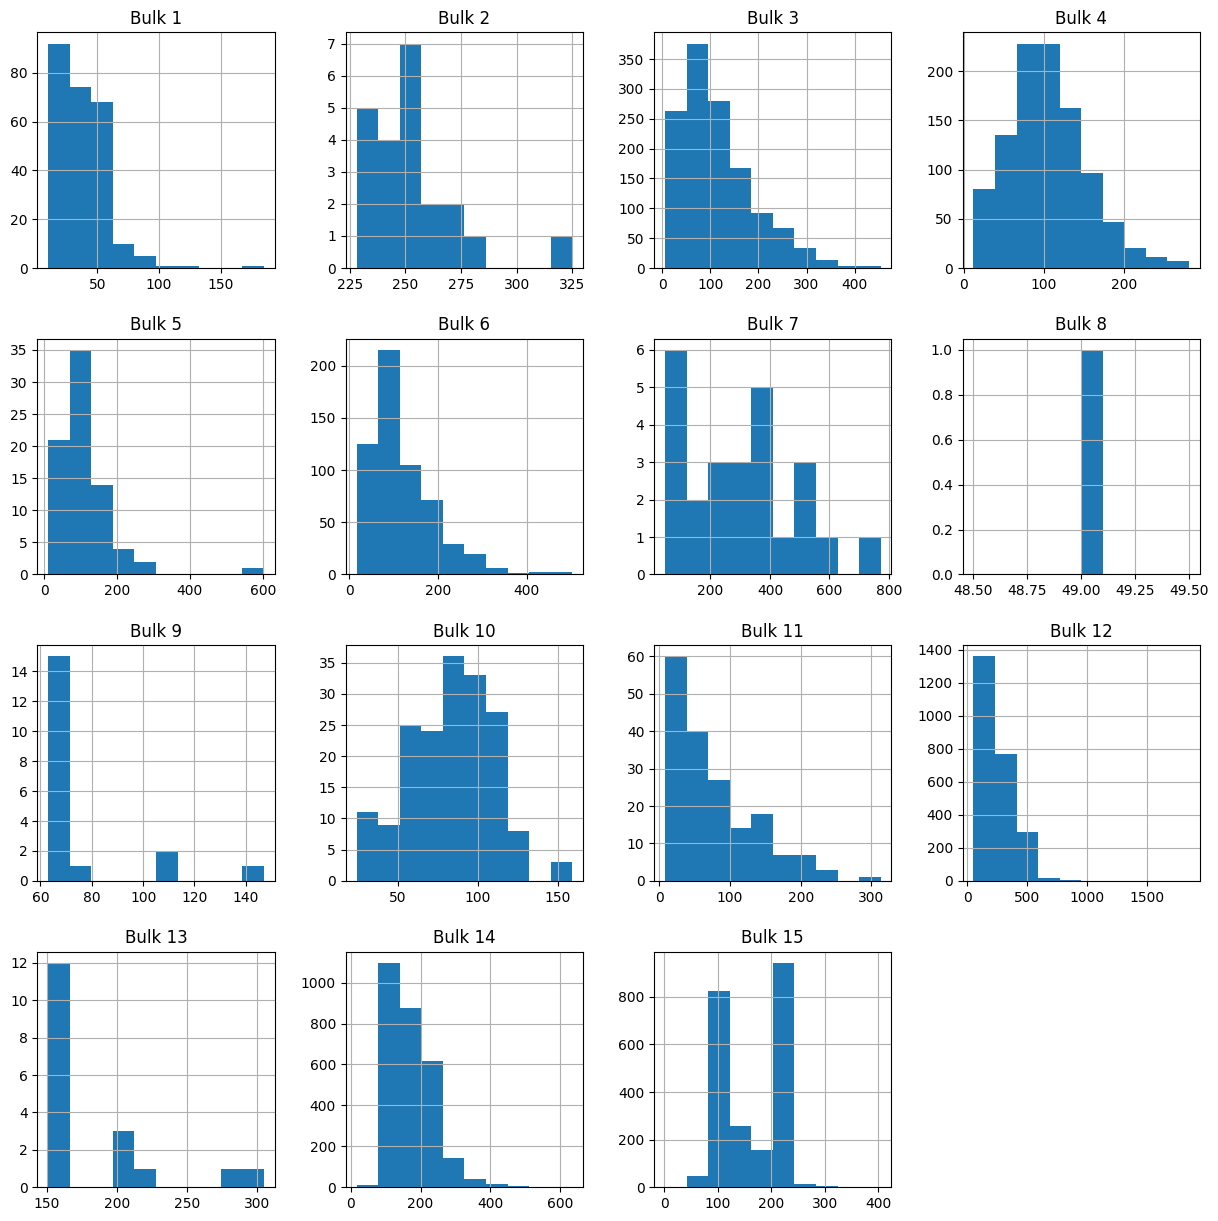

In [17]:
data_bulk.drop('key', axis=1).hist(figsize=(15, 15))
plt.show()

Также рассмотрим распределение суммарного объема добавленных примесей и количества добавлений примесей.

In [18]:
counter = [] # счетчик добавлений примесей
summary = [] # суммарный объем примесей

# функция для рассчета объема и количества добавлений примесей для каждой партии
for i in data_bulk.index:
    counter.append(data_bulk.loc[i].count() - 1)
    summary.append(data_bulk.loc[i].sum() - data_bulk.loc[i, 'key'])
data_bulk['count_bulk'] = counter
data_bulk['sum_bulk'] = summary

In [19]:
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,count_bulk,sum_bulk
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,4,553.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,4,582.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,4,544.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,4,595.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,4,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0,4,758.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0,4,594.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0,4,630.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0,3,272.0


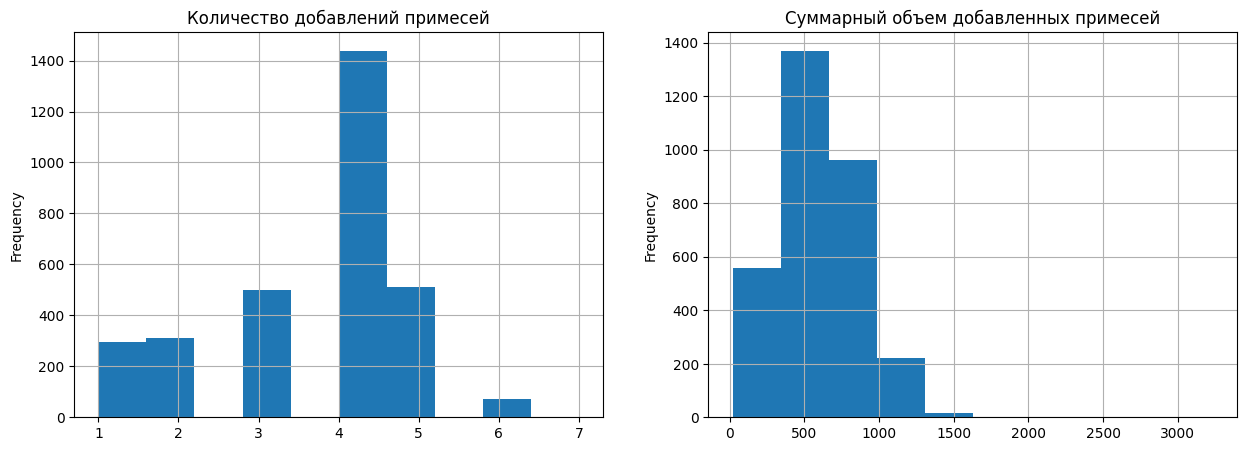

In [20]:
f, axs = plt.subplots(1, 2, figsize=(15, 5))
data_bulk['count_bulk'].plot(kind='hist', ax=axs[0], grid=True, title='Количество добавлений примесей')
data_bulk['sum_bulk'].plot(kind='hist', ax=axs[1], grid=True, title='Суммарный объем добавленных примесей')
plt.show()

Для большинства партий примеси добавляются в среднем 4 раза. Суммарный объем примесей в среднем варьируется от 0 до 1700.

#### Результаты анализа таблиц data_bulk и data_bulk_time

В данных таблицах много пропущенных значений, также в обеих таблицах отсутствуют данные для одних и тех же партий. Предположительно, пропуски означают то, что примеси на данном этапе не добавлялись.

В таблице data_bulk_time данные были приведены к корректному типу данных datetime.

Для большинства партий примеси добавляются в среднем 4 раза. Суммарный объем примесей в среднем варьируется от 0 до 1700 (выше - крайне редкие значения).

### data_gas

In [21]:
# вывод основной информации и пропусков в столбце key
data_info(data_gas)
print('Количество пропущенных партий:', len(passes(data_gas, length)))
print('Список пропущенных партий:', passes(data_gas, length))

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
Номера партий: [   1    2    3 ... 3239 3240 3241]
Количество пропущенных партий: 2
Список пропущенных партий: [193, 259]


В данных нет пропусков, типы даннных корректны. Отсутствуют данные для двух партий стали.

Рассмотрим распределение объема газа, используемого для продувки сплава.

<AxesSubplot:title={'center':'Распределение объема газа, используемого для продувки сплава'}, ylabel='Frequency'>

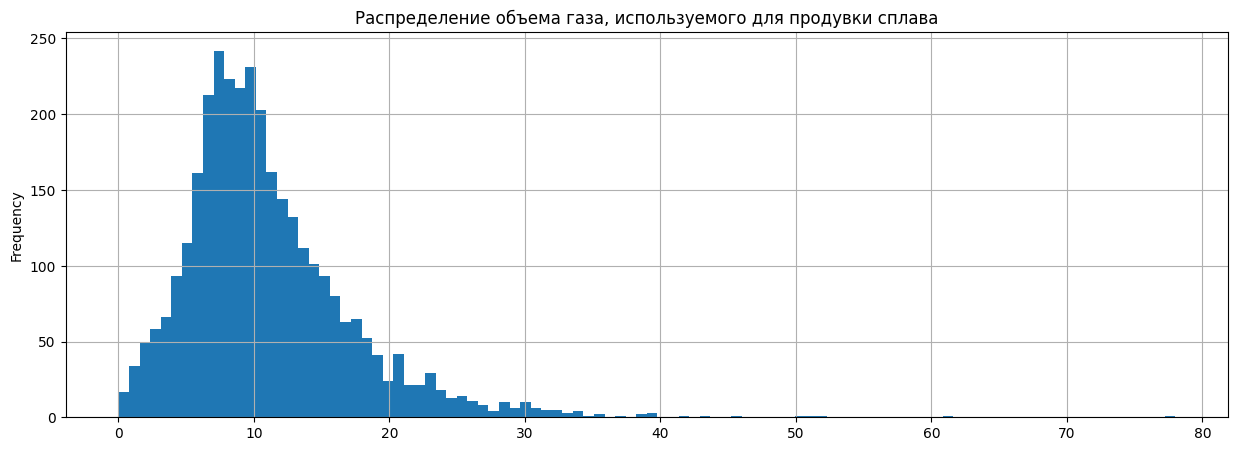

In [22]:
data_gas['Газ 1'].plot(kind='hist', bins=100, figsize=(15, 5), grid=True, 
                       title='Распределение объема газа, используемого для продувки сплава')

Распределение нормальное, объем добавляемого газа варьируется от 0 до 25. Значения выше можно считать аномалиями. Проверим данного предположение с помощью ящика с усами.

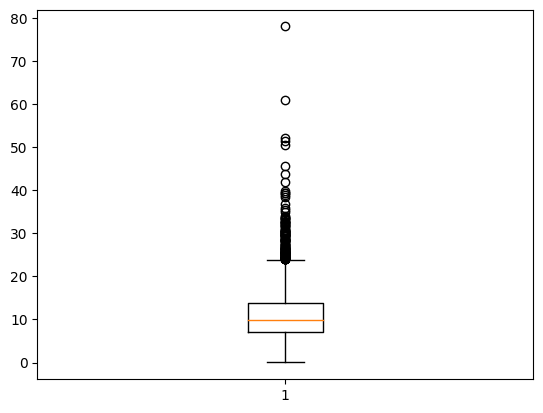

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

In [23]:
plt.boxplot(x=data_gas['Газ 1'])
plt.show()
data_gas['Газ 1'].describe()

Медианное значение добавляемого газа - 10, среднее - 11. Ящик с усами подтверждаем распределение основной массы значений между 0 и 25.

#### Результаты анализа таблицы data_gas

В таблице нет пропусков, отсутствуют данные по двум партиям.

Объем добавляемого газа распределен нормально, варьируется от 0 до 25.

Медианное значение добавляемого газа - 10, среднее - 11.

### data_temp

In [24]:
# вывод основной информации и пропусков в столбце key
data_info(data_temp)
print('Количество пропущенных партий:', len(passes(data_temp, length)))
print('Список пропущенных партий:', passes(data_temp, length))

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
Номера партий: [   1    2    3 ... 3239 3240 3241]
Количество пропущенных партий: 25
Список пропущенных партий: [41, 42, 355, 382, 506, 529, 540, 607, 683, 710, 766, 1133, 1300, 1437, 2031, 2103, 2278, 2356, 2373, 2446, 2469, 2491, 2683, 3200, 3207]


Отсутствуют данные для 25 партий.  
В столбце "Температура" пропущено около 20% значений.  
В столбце "Время замера" использован некорректный тип данных, приведем его к типу datetime.  

In [25]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

Отсортируем данные по номеру партии и времени замера, а также проверим наличие дубликатов в столбце "Время замера".

In [26]:
data_temp = data_temp.sort_values(by=['key', 'Время замера'])
data_temp['Время замера'].duplicated().sum()

0

Дубликатов нет.  
Создадим таблицу data_temp_by_keys, в которую войдут начальное и конечное время замера, а также начальная и конечная температура для каждой партии.

In [27]:
data_temp_by_keys = pd.pivot_table(data_temp, values='Время замера', index='key', aggfunc=['min', 'max'])
data_temp_by_keys['key'] = data_temp_by_keys.index
data_temp_by_keys.columns = ['Время замера', 'Время замера конечное', 'key']
data_temp_by_keys = data_temp_by_keys.merge(data_temp[['Время замера', 'Температура']], on='Время замера', how='inner')
data_temp_by_keys.columns = ['Время замера начальное', 'Время замера', 'key', 'Температура начальная']
data_temp_by_keys = data_temp_by_keys.merge(data_temp[['Время замера', 'Температура']], on='Время замера', how='inner')
data_temp_by_keys.columns = ['time_start', 'time_end', 'key', 'temp_start', 'temp_end']
data_temp_by_keys

,time_start,time_end,key,temp_start,temp_end
0,2019-05-03 11:16:18,2019-05-03 11:30:39,1,1571.0,1613.0
1,2019-05-03 11:37:27,2019-05-03 11:59:12,2,1581.0,1602.0
2,2019-05-03 12:13:17,2019-05-03 12:34:57,3,1596.0,1599.0
3,2019-05-03 12:52:57,2019-05-03 12:59:25,4,1601.0,1625.0
4,2019-05-03 13:23:19,2019-05-03 13:36:01,5,1576.0,1602.0
...,...,...,...,...,...
3211,2019-08-31 22:44:04,2019-08-31 23:05:43,3237,1569.0,NaN
3212,2019-08-31 23:30:31,2019-08-31 23:43:00,3238,1584.0,NaN
3213,2019-09-01 01:31:47,2019-09-01 02:24:15,3239,1598.0,NaN
3214,2019-09-01 02:39:01,2019-09-01 03:35:16,3240,1617.0,NaN


Не для всех партий имеются данные по начальной и конечной температуре. Посчитаем количество пропусков.

In [28]:
data_temp_by_keys.isna().sum()

time_start      0
time_end        0
key             0
temp_start      0
temp_end      739
dtype: int64

Удалим пропуски и построим график только по тем партиям, где присутствуют оба значений.

In [29]:
data_temp_by_keys = data_temp_by_keys.dropna()

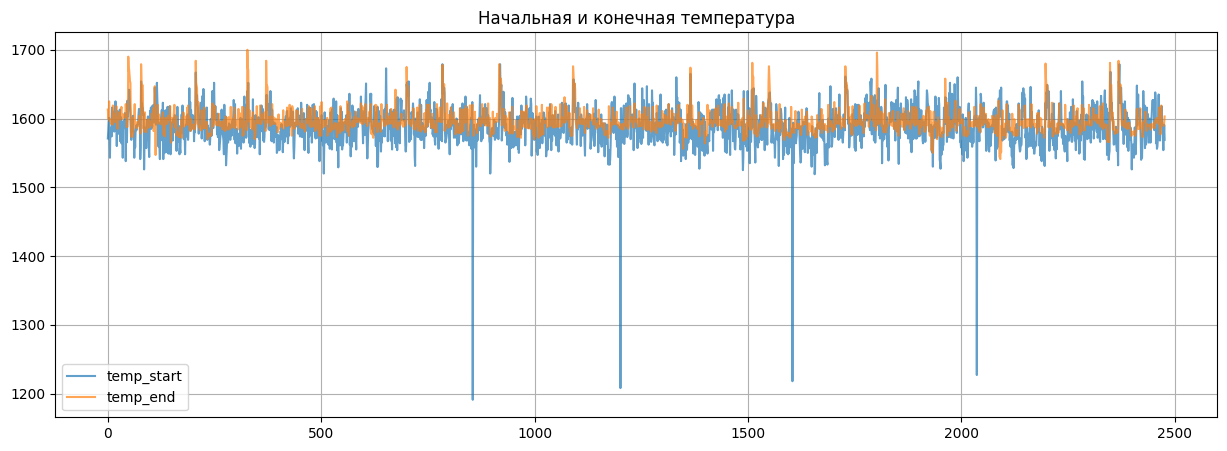

In [30]:
data_temp_by_keys[['temp_start', 'temp_end']].dropna().plot(figsize=(15, 5), grid=True, alpha=0.7,
                                                                                  title='Начальная и конечная температура')
plt.show()

У нескольких партий аномально низкие начальные температуры. Попробуем построить график только для тех партий, у которых начальная температура больше 1500.

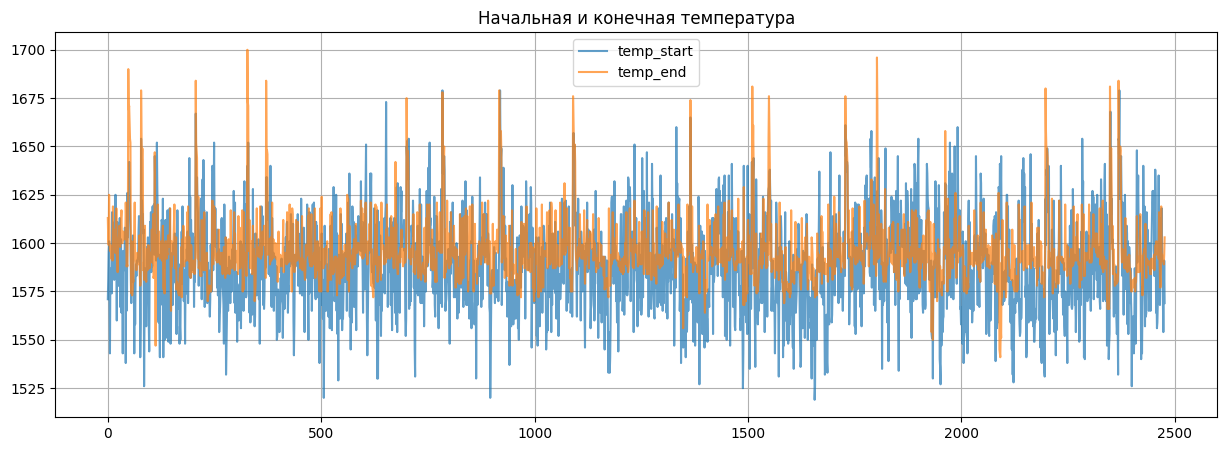

In [31]:
data_temp_by_keys[data_temp_by_keys['temp_start'] > 1500][['temp_start', 'temp_end']].dropna().plot(
    figsize=(15, 5), grid=True, alpha=0.7,title='Начальная и конечная температура')
plt.show()

На графике видно, что зачастую начальная температура выше конечной. Посчитаем количество таких строк.

In [32]:
print(len(data_temp_by_keys[data_temp_by_keys['temp_start'] > data_temp_by_keys['temp_end']]))

912


Практически в трети случаев начальная температура сплава выше конечной.

#### Результаты анализа таблицы data_temp

Отсутствуют данные для 25 партий.  В столбце "Температура" пропущено около 20% значений.

В столбце "Время замера" тип данных приведен к типу datetime.  

Для четверти партий отсутствуют значения конечной температуры.

В данных присутствуют несколько аномальных значений начальной температуры (менее 1500).

У трети партий начальная температура выше конечной.

### data_wire и data_wire_time

In [33]:
# вывод основной информации и пропусков в столбце key
data_info(data_wire)
print('Количество пропущенных партий:', len(passes(data_wire, length)))
print('Список пропущенных партий:', passes(data_wire, length))

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
Номера партий: [   1    2    3 ... 3239 3240 3241]
Количество пропущенных партий: 160
Список пропущенных партий: [41, 42, 51, 52, 53, 54, 55, 56, 81, 82, 83, 84, 85, 88, 109, 195, 197, 209, 210, 211, 212, 269, 330, 331, 332, 355, 375, 376, 377, 378, 382, 506, 529, 540, 607, 683, 710, 711, 712, 713, 714, 715, 744, 748, 754, 755, 766, 796, 797, 798, 799, 800, 841, 929, 930, 931, 932, 933, 934, 11

In [34]:
# вывод основной информации и пропусков в столбце key
data_info(data_wire_time)
print('Количество пропущенных партий:', len(passes(data_wire_time, length)))
print('Список пропущенных партий:', passes(data_wire_time, length))

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
Номера партий: [   1    2    3 ... 3239 3240 3241]
Количество пропущенных партий: 160
Список пропущенных партий: [41, 42, 51, 52, 53, 54, 55, 56, 81, 82, 83, 84, 85, 88, 109, 195, 197, 209, 210, 211, 212, 269, 330, 331, 332, 355, 375, 376, 377, 378, 382, 506, 529, 540, 607, 683, 710, 711, 712, 713, 714, 715, 744, 748, 754, 755, 766, 796, 797, 798, 799, 800, 841, 929, 930, 931, 932, 933, 934, 1102, 1103, 11

В данных таблицах много пропущенных значений, также в обеих таблицах отсутствуют данные для одних и тех же партий. Предположительно, пропуски означают то, что проволока на данном этапе не добавлялась.

Визуализируем данные в обеих таблицах.

AxesSubplot(0.125,0.11;0.698618x0.77)
AxesSubplot(0.125,0.11;0.698618x0.77)


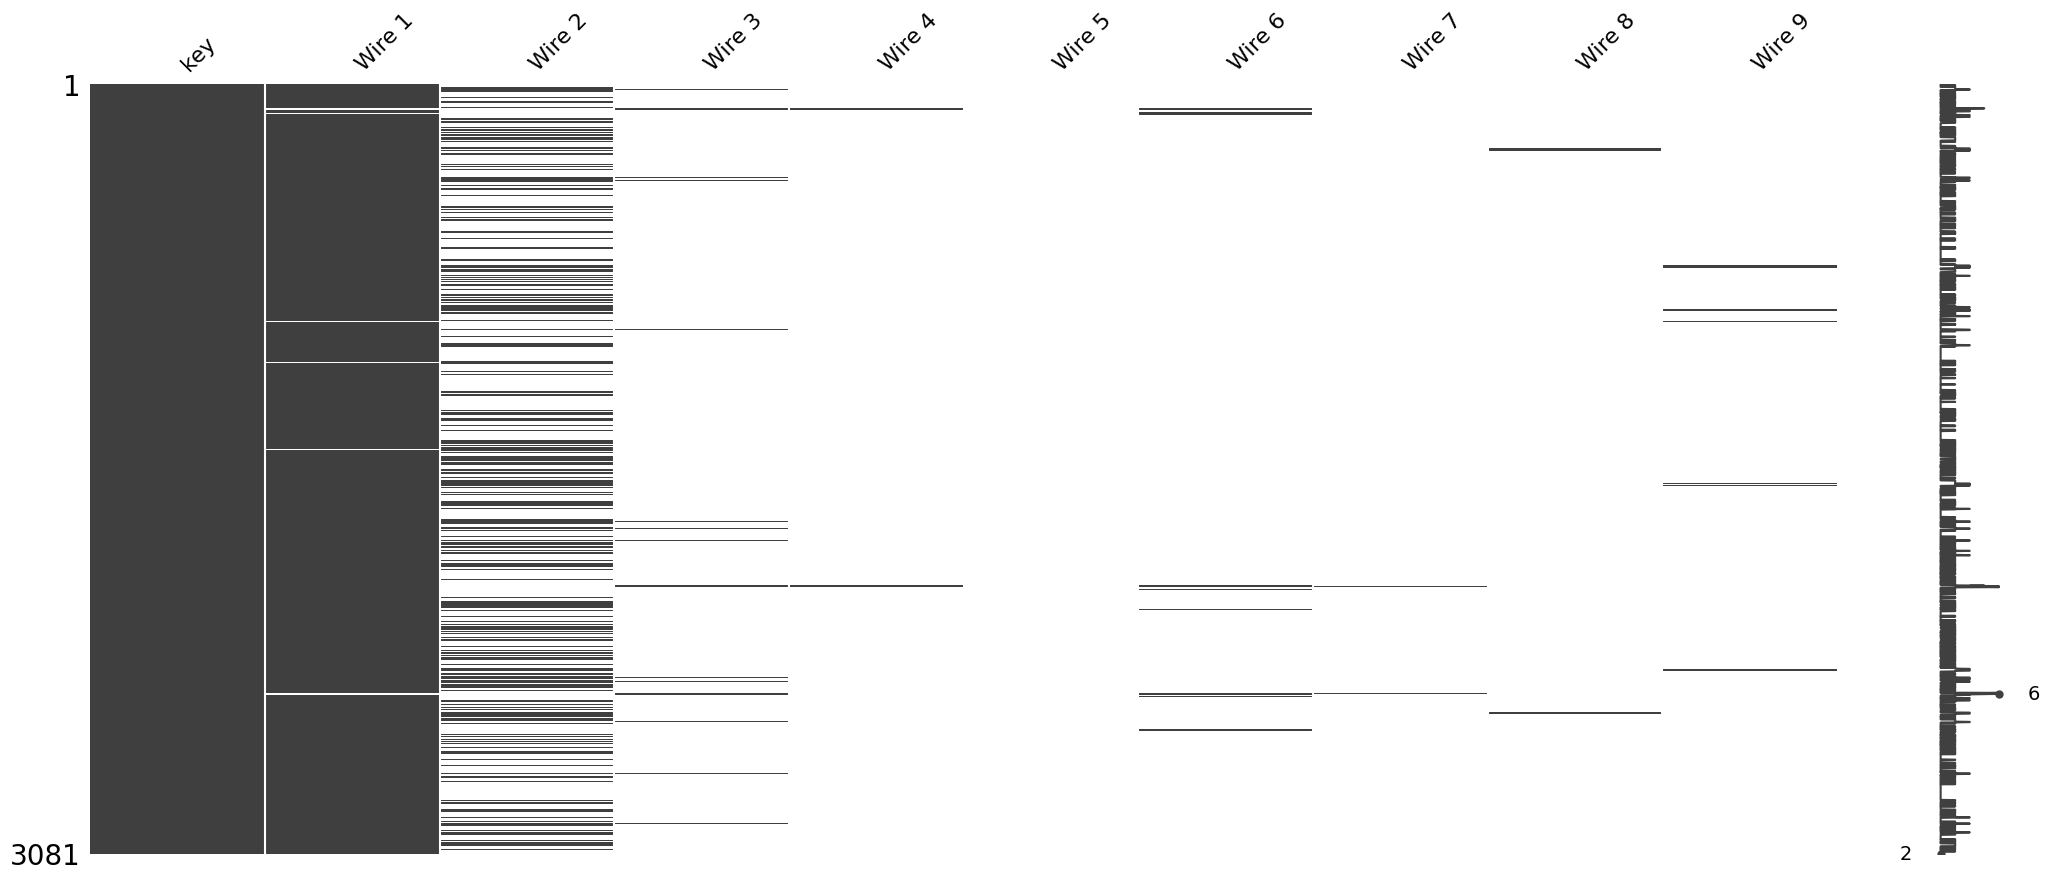

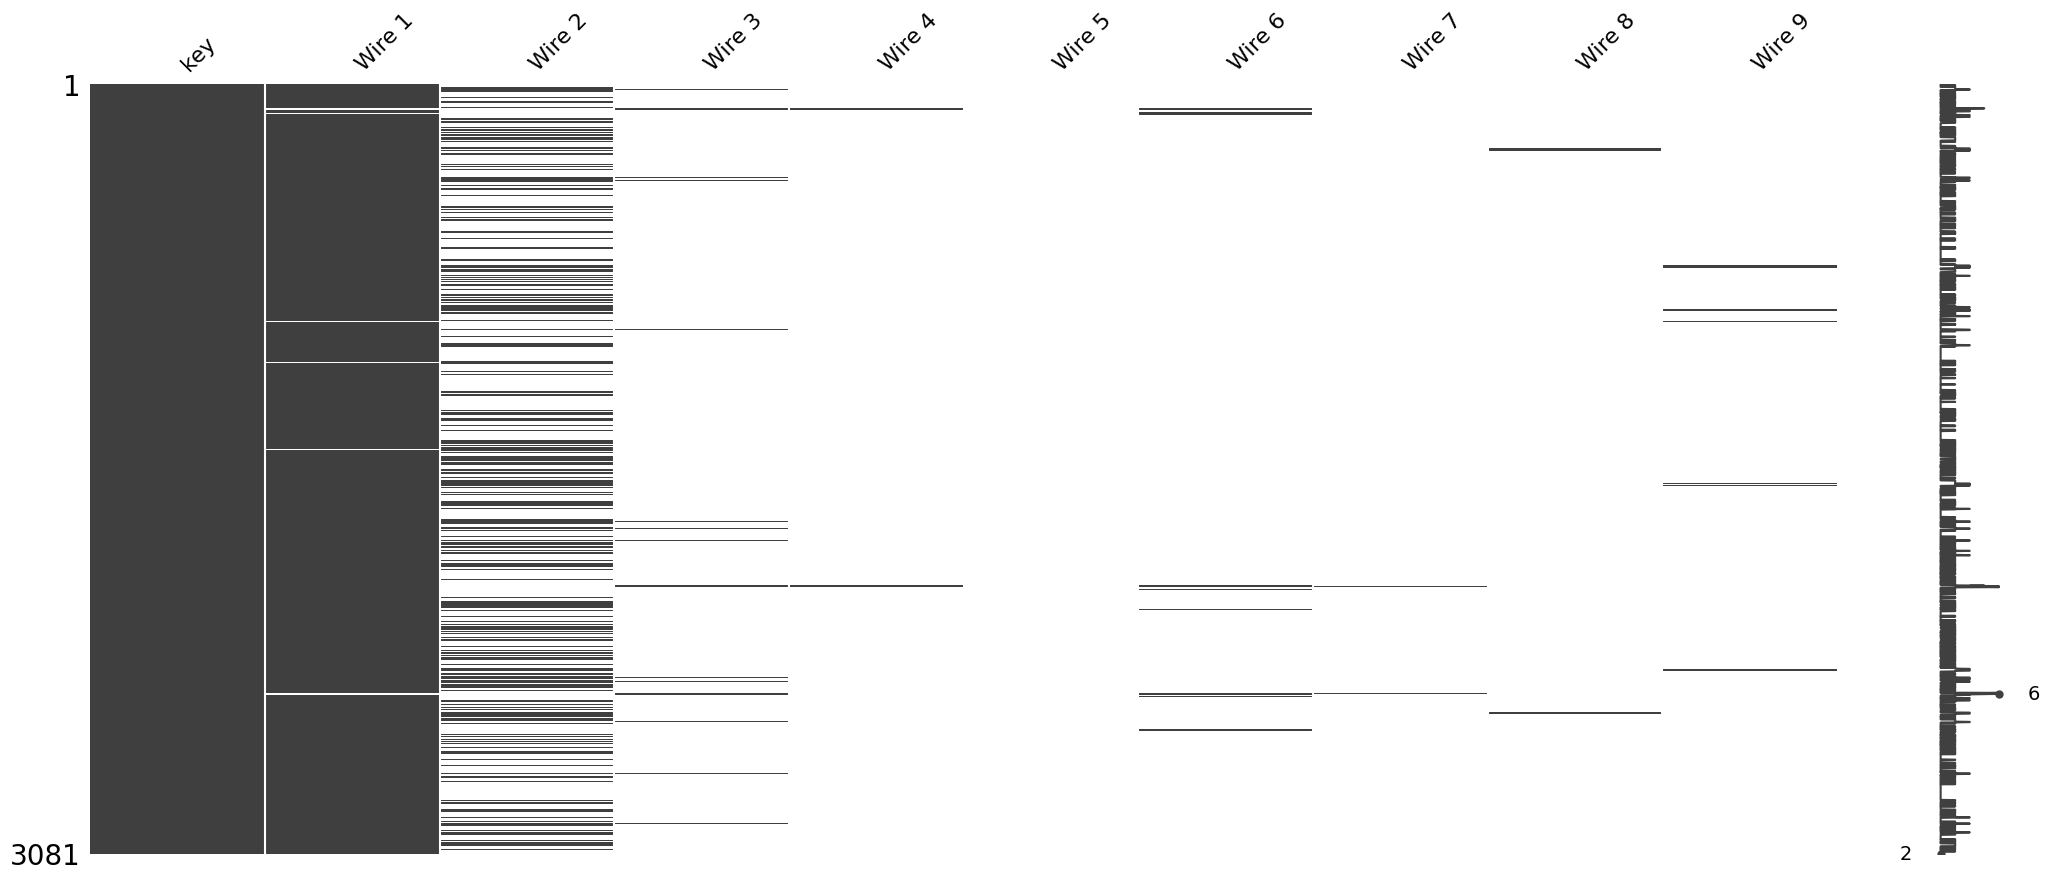

In [35]:
print(msno.matrix(data_wire))
print(msno.matrix(data_wire_time))

Графики идентичны, следовательно, пропуски одинаковы для обеих таблиц.

В таблице data_wire_time использованы некорректные типы данных. Приведем данные к типу datetime.

In [36]:
data_wire_time['Wire 1'] = pd.to_datetime(data_wire_time['Wire 1'], format='%Y-%m-%d %H:%M:%S')
data_wire_time['Wire 2'] = pd.to_datetime(data_wire_time['Wire 2'], format='%Y-%m-%d %H:%M:%S')
data_wire_time['Wire 3'] = pd.to_datetime(data_wire_time['Wire 3'], format='%Y-%m-%d %H:%M:%S')
data_wire_time['Wire 4'] = pd.to_datetime(data_wire_time['Wire 4'], format='%Y-%m-%d %H:%M:%S')
data_wire_time['Wire 5'] = pd.to_datetime(data_wire_time['Wire 5'], format='%Y-%m-%d %H:%M:%S')
data_wire_time['Wire 6'] = pd.to_datetime(data_wire_time['Wire 6'], format='%Y-%m-%d %H:%M:%S')
data_wire_time['Wire 7'] = pd.to_datetime(data_wire_time['Wire 7'], format='%Y-%m-%d %H:%M:%S')
data_wire_time['Wire 8'] = pd.to_datetime(data_wire_time['Wire 8'], format='%Y-%m-%d %H:%M:%S')
data_wire_time['Wire 9'] = pd.to_datetime(data_wire_time['Wire 9'], format='%Y-%m-%d %H:%M:%S')

Построим гистограммы по всем столбцам таблицы data_wire.

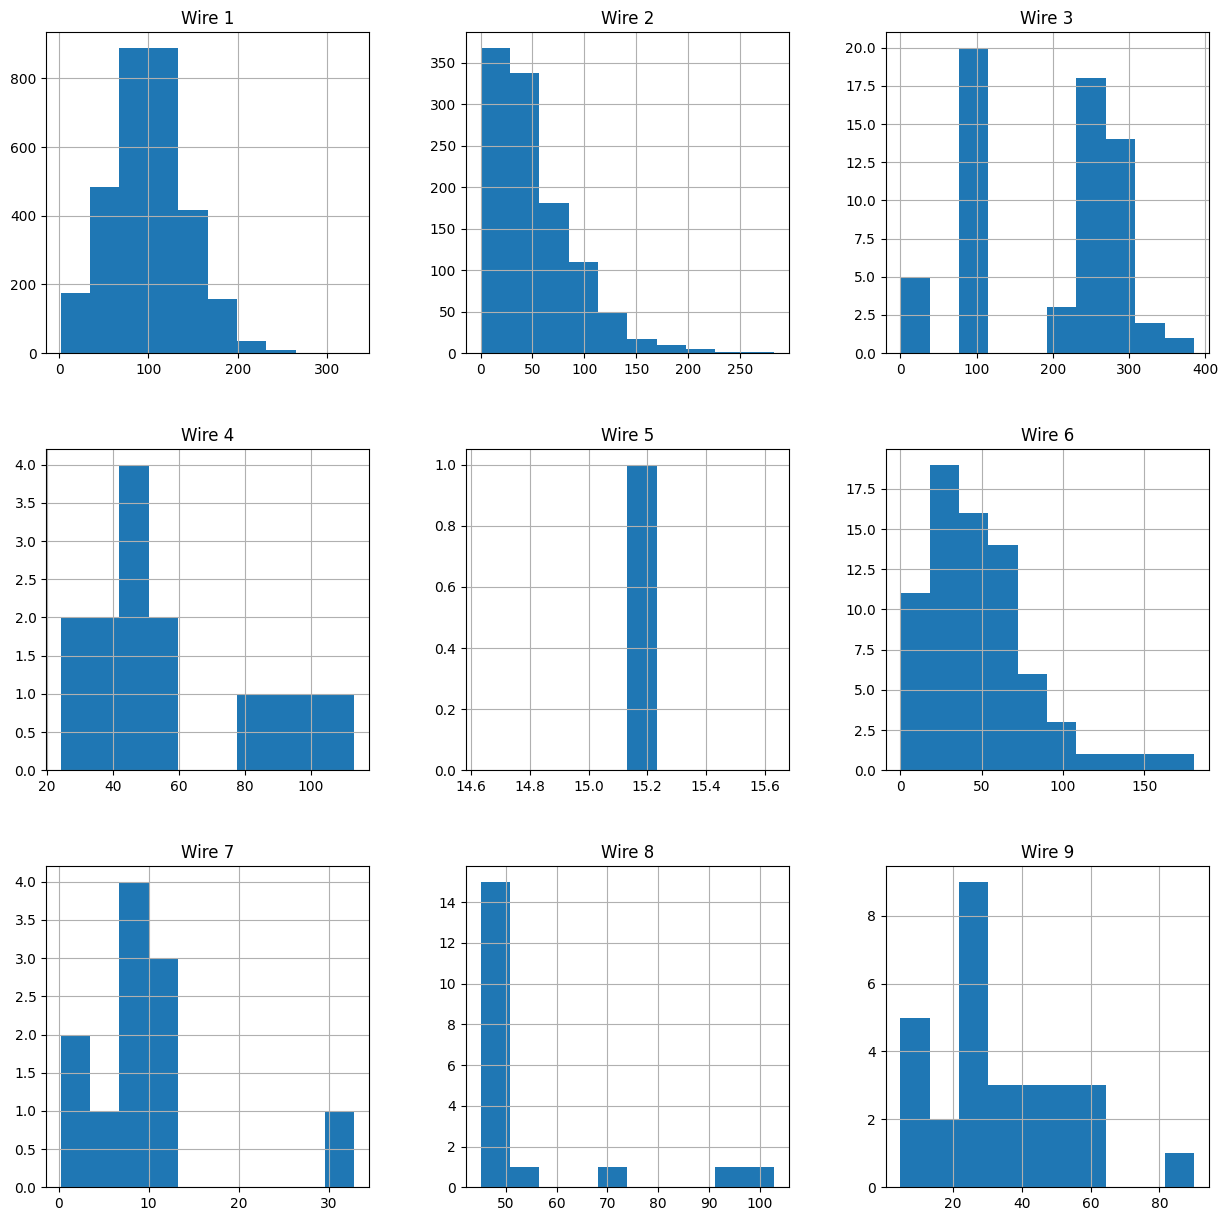

In [37]:
data_wire.drop('key', axis=1).hist(figsize=(15, 15))
plt.show()

Также рассмотрим распределение суммарного объема добавленной проволоки и количества добавлений проволоки.

In [38]:
counter = [] # счетчик добавлений проволоки
summary = [] # суммарный объем проволоки

# функция для рассчета объема и количества добавлений проволоки для каждой партии
for i in data_wire.index:
    counter.append(data_wire.loc[i].count() - 1)
    summary.append(data_wire.loc[i].sum() - data_wire.loc[i, 'key'])
data_wire['count_wire'] = counter
data_wire['sum_wire'] = summary

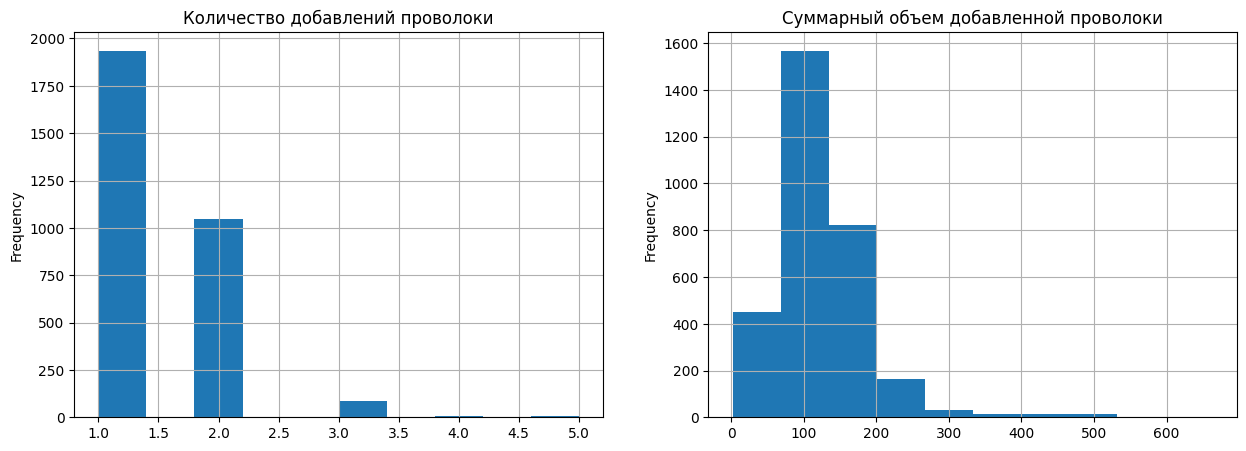

In [39]:
f, axs = plt.subplots(1, 2, figsize=(15, 5))
data_wire['count_wire'].plot(kind='hist', ax=axs[0], grid=True, title='Количество добавлений проволоки')
data_wire['sum_wire'].plot(kind='hist', ax=axs[1], grid=True, title='Суммарный объем добавленной проволоки')
plt.show()

Для большинства партий проволока добавляется в среднем 1-2 раза. Суммарный объем проволоки в среднем варьируется от 0 до 400.

#### Результаты анализа таблиц data_wire и data_wire_time

В данных таблицах много пропущенных значений, также в обеих таблицах отсутствуют данные для одних и тех же партий. Предположительно, пропуски означают то, что проволока на данном этапе не добавлялась.

В таблице data_wire_time данные были приведены к корректному типу данных datetime.

Для большинства партий проволока добавляется в среднем 1-2 раза. Суммарный объем проволоки в среднем варьируется от 0 до 400.

### Итоги анализа данных

Исходя из первичного анализа предоставленных таблиц можно сделать следующие выводы:

- В таблицах представлены данные для номеров партий от 1 до 3241, однако для некоторых партий данные отсутствуют (для разных в разных датафреймах).
- В таблице data_arc (данные об электродах) отсутствуют пропуски, для каждой партии могут быть несколько этапов подогрева (от 1 до 10, в среднем 4-5), присутствует линейная зависимость между активной и реактивной мощностью.
- В таблицах data_bulk и data_bulk_time (данные о подаче сыпучих материалов) большое количество пропусков, в двух таблицах пропуски одинаковы для одних и тех же партий. Полагаю, что пропуски означают, что на указанном этапе подача сыпучих материалов не производилась. Для большинства партий примеси добавляются в среднем 4 раза. Суммарный объем примесей в среднем варьируется от 0 до 1500.
- В таблице data_gas (данные о продувке сплава газом) пропусков нет. Объем добавляемого газа варьируется от 0 до 25, медианное значение - 10, среднее - 11.
- В таблице data_temp (результаты измерения температуры) отсутсвуют пропуски с временем измерения, однако пропущено почти 20% значений температуры. В четверти случаев отсутствует конечная температура, в трети случаев - начальная температура превышает конечную.
- В таблицах data_wire и data_wire_time (данные о проволочных материалах) большое количество пропусков, в двух таблицах пропуски одинаковы для одних и тех же партий. Полагаю, что пропуски означают, что на указанном этапе подача проволочных материалов не производилась. Для большинства партий проволока добавляется в среднем 1-2 раза. Суммарный объем примесей в среднем варьируется от 0 до 400.

## Предварительный план работы

1. Провести предобработку данных:
- обработать пропуски
- обработать аномалии
- исключить из анализа партии, для которых отсутсвует начальная либо конечная температура
2. Объединить таблицы, определить признаки и целевой признак (возможно, отбросить часть признаков)
3. Подготовить признаки и целевой признак к обучению моделей:
- провести разделение на обучающую и тестовую выборки
- масштабировать количественные признаки
3. Обучение моделей:
- обучить несколько моделей с использованием кросс-валидации (линейная регрессия, случайный лес, LightGBM, CatBoost)
- достичь значение MAE не более 6.8
- провести проверку модели на адекватность
4. Проверить модель с лучшим показателем MAE на тестовой выборке

## Предобработка данных

Для обучения моделей будут использованы следующие признаки:
- суммарная энергия, использованная для нагрева одной партии
- количество нагреваний одной партии
- объем использованного газа
- начальная температура партии
- суммарный объем добавленных примесей
- количество добавлений примесей
- суммарный объем добавленной проволоки
- количество добавлений проволоки

Целевой признак - конечная температура.

Для обучения моделей будут использованы только те партии, у которых:
- есть начальная и конечная температура
- есть данные по добавкам газа, примесей и проволоки

Часть из указанных выше признаков отсутствуют, их необходимо вывести из имеющихся данных.

### Суммарная энергия и количество нагреваний

Затраченная энергия - это произведение времени нагрева на полную мощность.
Полная мощность состоит из активной и реактивной мощности и вычисляется по теореме Пифагора.

In [40]:
# создание столбца duration с продолжительностью нагрева
data_arc['duration'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds

# создание солбца full_power с полной мощностью
data_arc['full_power'] = (data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2) ** 0.5

# создание столбца energy с разчетом затраченной энергии
data_arc['energy'] = data_arc['full_power'] * data_arc['duration']

# создание сводной таблицы data_arc_by_keys с суммарными данными по затраченной энергии для каждой партии
data_arc_by_keys = pd.pivot_table(data_arc, values='energy', index='key', aggfunc=['sum', 'count'])
data_arc_by_keys.columns = ['sum_energy', 'count_energy']

### Добавленные примеси и проволока

При анализе данных в таблицах data_wire и data_bulk були созданы дополнительные столбцы с суммарным объемом и количеством добавок.  
Проверим наличие пропусков в данных столбцах.

In [41]:
print('Количество пропусков в столбце sum_bulk:', data_bulk['sum_bulk'].isna().sum())
print('Количество пропусков в столбце count_bulk:', data_bulk['count_bulk'].isna().sum())
print('Количество пропусков в столбце sum_wire:', data_wire['sum_wire'].isna().sum())
print('Количество пропусков в столбце count_wire:', data_wire['count_wire'].isna().sum())

Количество пропусков в столбце sum_bulk: 0
Количество пропусков в столбце count_bulk: 0
Количество пропусков в столбце sum_wire: 0
Количество пропусков в столбце count_wire: 0


### Газ и температура

В таблице data_gas отсутствовали пропуски, дополнительная обработка данной таблице не требуется.  

Также ранее были сохранены начальные и конечные значения температур для каждой партии в таблицу data_temp_by_keys, а также удалены строки с пропусками.

### Объединение таблиц

Создадим таблицу data со всеми перечисленными выше признаками.

In [42]:
# переименование столбцов в таблице data_gas
data_gas.columns = ['key', 'gas']

# соединение таблиц data_arc_by_keys и data_gas
data = data_arc_by_keys.merge(data_gas, on='key', how='inner')

# присоединение данных из таблицы data_temp_by_keys (начальная и конечная температура)
data = data.merge(data_temp_by_keys[['key', 'temp_start', 'temp_end']], on='key', how='inner')

# присоединение данных из таблицы data_wire (суммарный объем и количество добавлений примесей)
data = data.merge(data_bulk[['key', 'sum_bulk', 'count_bulk']], on='key', how='inner')

# присоединение данных из таблицы data_bulk (суммарный объем и количество добавлений проволоки)
data = data.merge(data_wire[['key', 'sum_wire', 'count_wire']], on='key', how='inner')

# сортировка полученной таблицы по ключу
data = data.sort_values(by='key', ignore_index=True)

Рассмотрим основую информацию по таблице data.

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2329 non-null   int64  
 1   sum_energy    2329 non-null   float64
 2   count_energy  2329 non-null   int64  
 3   gas           2329 non-null   float64
 4   temp_start    2329 non-null   float64
 5   temp_end      2329 non-null   float64
 6   sum_bulk      2329 non-null   float64
 7   count_bulk    2329 non-null   int64  
 8   sum_wire      2329 non-null   float64
 9   count_wire    2329 non-null   int64  
dtypes: float64(6), int64(4)
memory usage: 182.1 KB


Пропусков нет, типы данных корректные, все признаки количественные.  

Так как при анализе данных в некоторых таблицах были выявлены аномальные значения, еще раз вглянем на гистограммы признаков, чтобы избавиться от аномальных значений.

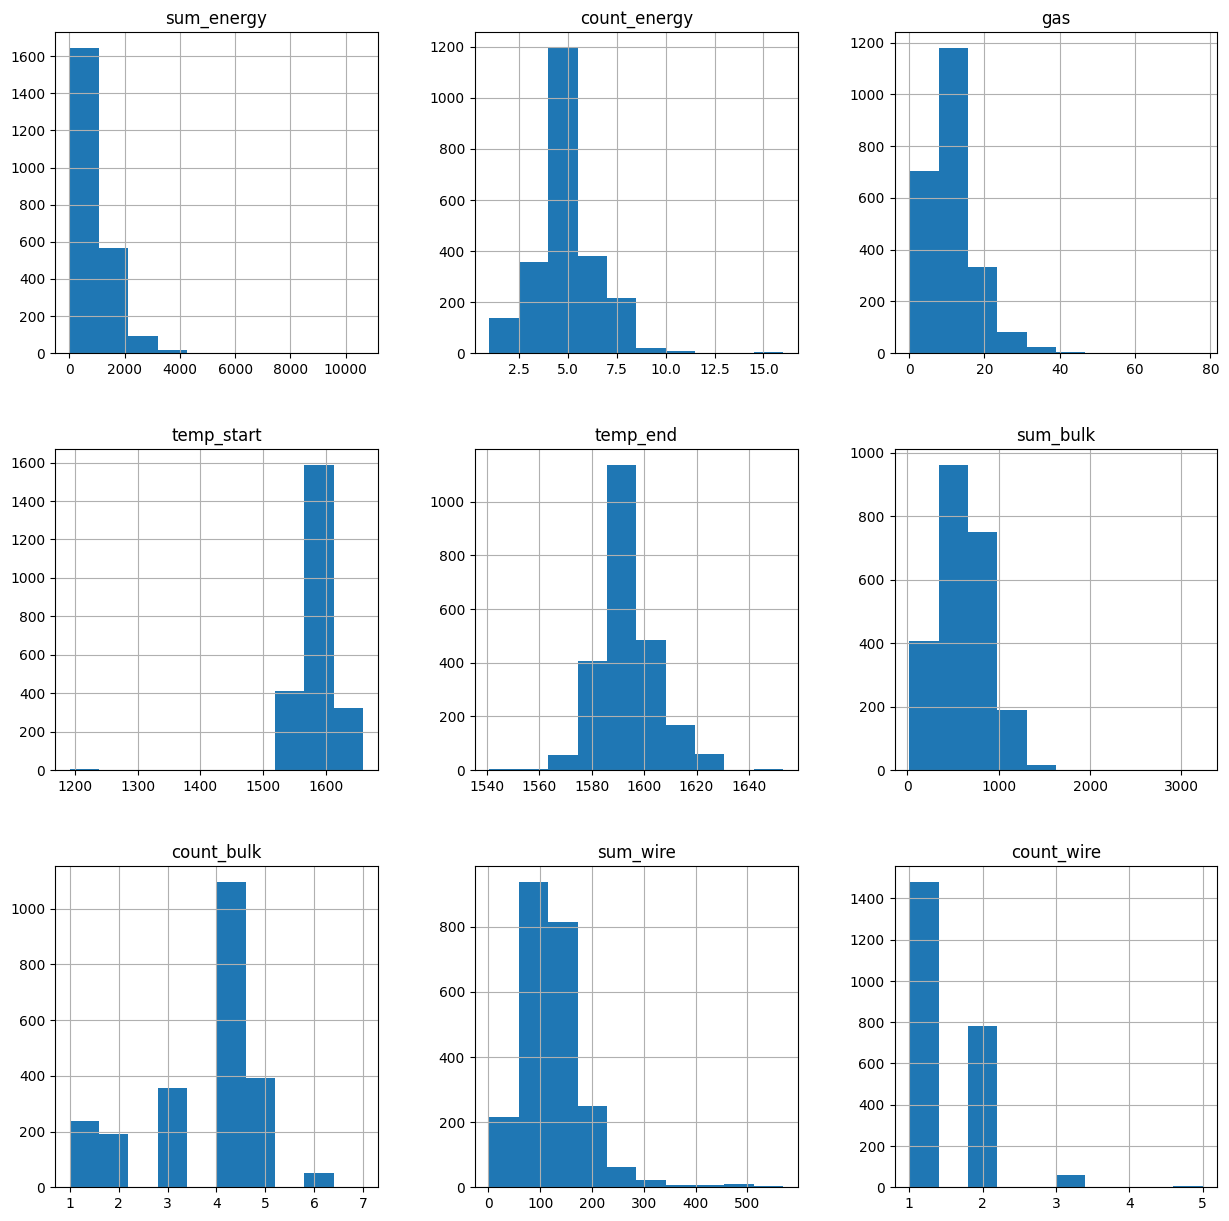

In [44]:
data.drop('key', axis=1).hist(figsize=(15, 15))
plt.show()

Ограничим значения следующим образом:
- суммарная энергия - не более 5000
- объем газа - не более 50
- начальная температура - не менее 1500
- суммарный объем примесей - не более 4000

Данные ограничения применим ниже, только на обучающей выборке, после разделения данных.

Также рассмотрим корреляцию признаков между собой.

interval columns not set, guessing: ['key', 'sum_energy', 'count_energy', 'gas', 'temp_start', 'temp_end', 'sum_bulk', 'count_bulk', 'sum_wire', 'count_wire']


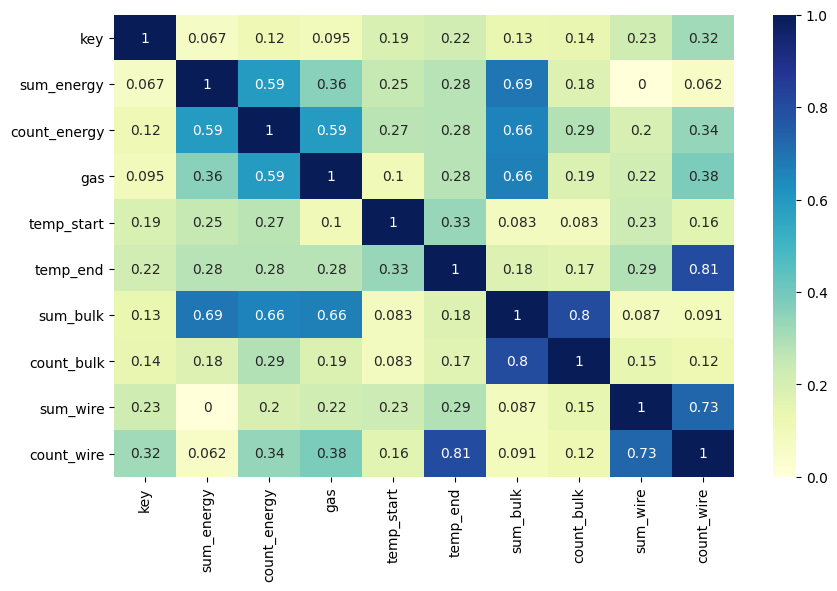

In [45]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.phik_matrix(), annot=True, vmin=0, vmax=1, fmt='.2g', cmap='YlGnBu')
plt.show()

Существенно коррелирующие между собой признаки:
- суммарная энергия и количество нагреваний
- конечная температура и количество добавлений проволоки
- объем примесей и количество добавлений примесей
- объем проволоки и количество добавлений проволоки

Признаки готовы, перейдем к обучению моделей.

## Обучение моделей

Обучим 5 моделей:
- линейная регрессия
- дерево решений
- случайный лес
- градиентный бустинг CatBoost
- градиентный бустинг Light GBM

Для всех моделей, кроме линейной регрессии, подбор гиперпараметров и кросс-валидация будут выполнены с помощью GridSearchCV.

Целевое значение MAE и random_state сохраним в отдельные переменные.

In [46]:
random_state = 160123
target_mae = 6.8

### Подготовка данных к обучению

In [47]:
# разделение данных на обучающую и тестовую выборки
train, test = train_test_split(data, test_size=0.25, random_state=random_state)

# удаление аномальных значений из обучающей выборки
train = train[train['sum_energy'] < 5000]
train = train[train['gas'] < 50]
train = train[train['temp_start'] > 1500]
train = train[train['sum_bulk'] < 4000]

# разделение выборок на признаки и целевой признак
features_train = train.drop(['key', 'temp_end'], axis=1)
target_train = train['temp_end']

features_test = test.drop(['key', 'temp_end'], axis=1)
target_test = test['temp_end']

# масштабирование признаков для линейной регрессии (данные состоят только из количественных признаков)
scaler = StandardScaler()
scaler.fit(features_train)
features_train_lr = scaler.transform(features_train)
features_test_lr = scaler.transform(features_test)
pd.options.mode.chained_assignment = None

### Линейная регрессия

In [48]:
%%time

model_lr = LinearRegression()
scores_lr = cross_val_score(model_lr, features_train_lr, target_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
mae_lr = scores_lr.mean() * -1
print('MAE на обучающей выборке', mae_lr)

if mae_lr < target_mae:
    print('Удалось достигнуть целевого уровня MAE на обучающей выборке')
else:
    print('Не удалось достигнуть целевого уровня MAE')

MAE на обучающей выборке 6.733774939956824
Удалось достигнуть целевого уровня MAE на обучающей выборке
CPU times: total: 15.6 ms
Wall time: 152 ms


### Дерево решений

In [49]:
%%time

params_dtr = {
    'max_depth': range(2, 7),
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(1, 5)
}

model_dtr = DecisionTreeRegressor(random_state=random_state)
grid_dtr = GridSearchCV(model_dtr, params_dtr, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid_dtr.fit(features_train, target_train)

mae_dtr = grid_dtr.best_score_ * -1

print('MAE на обучающей выборке', mae_dtr)
print('Лучшие гиперпараметры дерева решений', grid_dtr.best_params_)

if mae_dtr < target_mae:
    print('Удалось достигнуть целевого уровня MAE на обучающей выборке')
else:
    print('Не удалось достигнуть целевого уровня MAE')

MAE на обучающей выборке 7.329876301322555
Лучшие гиперпараметры дерева решений {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}
Не удалось достигнуть целевого уровня MAE
CPU times: total: 328 ms
Wall time: 717 ms


### Случайный лес

In [50]:
%%time

params_rfr = {
    'n_estimators': range(100, 301, 50),
    'max_depth': range(2, 7),
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(1, 5)
}

model_rfr = RandomForestRegressor(random_state=random_state)
grid_rfr = GridSearchCV(model_rfr, params_rfr, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid_rfr.fit(features_train, target_train)

mae_rfr = grid_rfr.best_score_ * -1

print('MAE на обучающей выборке', mae_rfr)
print('Лучшие гиперпараметры случайного леса', grid_rfr.best_params_)

if mae_rfr < target_mae:
    print('Удалось достигнуть целевого уровня MAE на обучающей выборке')
else:
    print('Не удалось достигнуть целевого уровня MAE')

MAE на обучающей выборке 6.598428952971136
Лучшие гиперпараметры случайного леса {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Удалось достигнуть целевого уровня MAE на обучающей выборке
CPU times: total: 6.28 s
Wall time: 3min 18s


### Градиентный бустинг CatBoost

In [51]:
%%time

params_cb = {
    'max_depth': range(2, 7),
    'learning_rate': (0.01, 0.001, 0.0001),
}

model_cb = CatBoostRegressor(random_state=random_state)
grid_cb = GridSearchCV(model_cb, params_cb, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid_cb.fit(features_train, target_train, verbose=False)

mae_cb = grid_cb.best_score_ * -1

print('MAE на обучающей выборке', mae_cb)
print('Лучшие гиперпараметры CatBoost', grid_cb.best_params_)

if mae_cb < target_mae:
    print('Удалось достигнуть целевого уровня MAE на обучающей выборке')
else:
    print('Не удалось достигнуть целевого уровня MAE')

MAE на обучающей выборке 6.507221832884289
Лучшие гиперпараметры CatBoost {'learning_rate': 0.01, 'max_depth': 6}
Удалось достигнуть целевого уровня MAE на обучающей выборке
CPU times: total: 9.39 s
Wall time: 37.4 s


### Градиентный бустинг Light GBM

In [52]:
%%time

params_lgbm = {
    'n_estimators': range(50, 301, 50),
    'max_depth': range(2, 7),
    'learning_rate': (0.01, 0.001, 0.0001),
}

model_lgbm = LGBMRegressor(random_state=random_state)
grid_lgbm = GridSearchCV(model_lgbm, params_lgbm, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid_lgbm.fit(features_train, target_train)

mae_lgbm = grid_lgbm.best_score_ * -1

print('MAE на обучающей выборке', mae_lgbm)
print('Лучшие гиперпараметры Light GBM', grid_lgbm.best_params_)

if mae_lgbm < target_mae:
    print('Удалось достигнуть целевого уровня MAE на обучающей выборке')
else:
    print('Не удалось достигнуть целевого уровня MAE')

MAE на обучающей выборке 6.599700704576629
Лучшие гиперпараметры Light GBM {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
Удалось достигнуть целевого уровня MAE на обучающей выборке
CPU times: total: 2.11 s
Wall time: 10.5 s


### Итоги обучения

In [53]:
models = ['Линейная регрессия', 'Дерево решений', 'Случайный лес', 'Градиентный бустинг CatBoost', 'Градиентный бустинг Light GBM']
results = pd.DataFrame(
    [[mae_lr, mae_lr < target_mae],
    [mae_dtr, mae_dtr < target_mae],
    [mae_rfr, mae_rfr < target_mae],
    [mae_cb, mae_cb < target_mae],
    [mae_lgbm, mae_lgbm < target_mae]],
    index=models,
    columns=['MAE', 'Значение MAE ниже порога']
)
results

,MAE,Значение MAE ниже порога
Линейная регрессия,6.733775,True
Дерево решений,7.329876,False
Случайный лес,6.598429,True
Градиентный бустинг CatBoost,6.507222,True
Градиентный бустинг Light GBM,6.599701,True


По результатам обучения 4 из 5 моделей удалось достичь целевого значения MAE.  
Минимальное значение MAE удалось получить при использовании градиентного бустинга CatBoost со следующими параметрами:
- learning_rate 0.01
- max_depth 6

Проверим данную модель на тестовой выборке.

## Тестирование модели

In [54]:
predictions = grid_cb.predict(features_test)
mae = mean_absolute_error(target_test, predictions)
print(mae)

if mae < target_mae:
    print('Удалось достигнуть целевого уровня MAE на тестовой выборке')
else:
    print('Не удалось достигнуть целевого уровня MAE')

6.393957503789935
Удалось достигнуть целевого уровня MAE на тестовой выборке


На тестовой выборке CatBoost выдает более низкое значение MAE, чем на обучающей выборке, следовательно, переобучения нет.

## Проверка модели на адекватность

Для того, чтобы убедиться в целесообразности использования модели, проверим модель на адекватность, сравнив ее с dummy-мделью, которая по умолчанию предсказывает медианную температуру.

In [55]:
%%time

model_dummy = DummyRegressor(strategy='median')
model_dummy.fit(features_train, target_train)
predictions_dummy = model_dummy.predict(features_test)
mae_dummy = mean_absolute_error(target_test, predictions_dummy)

print('MAE dummy-модели', mae_dummy)

if mae_dummy < target_mae:
    print('Удалось достигнуть целевого уровня MAE на тестовой выборке')
else:
    print('Не удалось достигнуть целевого уровня MAE')

MAE dummy-модели 7.927958833619211
Не удалось достигнуть целевого уровня MAE
CPU times: total: 46.9 ms
Wall time: 1.99 ms


Dummy-модель выдает значение MAE выше, чем любая из обученных ранее моделей. Соответственно, использование выбранной модели CatBoost целесообразно.

## Выводы по результатам обучения моделей

Были обучены 5 моделей:

- линейная регрессия
- дерево решений
- случайный лес
- градиентный бустинг CatBoost
- градиентный бустинг Light GBM

Для всех моделей, кроме линейной регрессии, подбор гиперпараметров и кросс-валидация выполнен с помощью GridSearchCV.
Для линейной регрессии проведено масштабирование признаков и кросс-валидация.
Количество блоков для кросс-валидации во всех случаях равно 5.

Для обучения всех моделей, а также деления выборки на обучающую и тестовую использован random_state=160123.

Пороговое значение MAE=6.8.

По результатам обучения моделей получены следующие результаты:

In [56]:
results

,MAE,Значение MAE ниже порога
Линейная регрессия,6.733775,True
Дерево решений,7.329876,False
Случайный лес,6.598429,True
Градиентный бустинг CatBoost,6.507222,True
Градиентный бустинг Light GBM,6.599701,True


По результатам обучения 4 из 5 моделей удалось достичь целевого значения MAE.  
Минимальное значение MAE удалось получить при использовании градиентного бустинга CatBoost со следующими параметрами:
- learning_rate 0.01
- max_depth 6

На тестовой выборке CatBoost выдает значение MAE 6.4.

Для проверки данной модели на адекватность, была также обучена dummy-мдель, которая по умолчанию предсказывает медианную температуру.

Dummy-модель выдает значение MAE значительно выше, чем выбранная модель CatBoost.   
Соответственно, использование модели CatBoost целесообразно

## Отчет по выполненной работе

**Задача**   
Данная работа выполнялась с целью снижения расходов на электроэнергию путем построения модели, способной предсказывать температуру стали на этапе ее обработки.  
Заданное пороговое значение среднего абсолютного отклонения 6.8.
  
**Описание данных**  
В работе были использованы следующие источники с информацией об этапах обработки стали:
- data_arc — данные об электродах;
- data_bulk — данные о подаче сыпучих материалов (объём);
- data_bulk_time — данные о подаче сыпучих материалов (время);
- data_gas — данные о продувке сплава газом;
- data_temp — результаты измерения температуры;
- data_wire — данные о проволочных материалах (объём);
- data_wire_time — данные о проволочных материалах (время).  

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

**Этап 1. Анализ данных**  
Первым этапом был проведен исследовательский анализ данных.  
По каждой таблице была изучена основная информация, первые несколько строк, а также были построены графики распределения данных.  
В каждой таблице полностью отсутствуют данные по некоторым партиям, при чем для разных в разных таблицах. Количество пропущенных партий также варьируется.  

Также в результате анализа были выявлены следующие особенности:
1. таблица data_arc:
- в таблице отсутствуют пропуски
- столбцы с датой и временем приведены к корректному типу данных
- количество нагреваний каждой партии стали распределено нормально, подавляющее большинство партий нагревается от 1 до 10 раз
- был обнаружен один выброс в значениях реактивной мощности, после удаления которого была выявлена сильная линейная зависимость между активной и реактивной мощностью
2. таблицы data_bulk и data_bulk_time:
- в таблицах много пропущенных значений, также в обеих таблицах отсутствуют данные для одних и тех же партий
- предположительно, пропуски означают то, что примеси на данном этапе не добавлялись
- столбцы с датой и временем в таблице data_bulk_time приведены к корректному типу данных
- для большинства партий примеси добавляются в среднем 4 раза
- суммарный объем примесей в среднем варьируется от 0 до 1700 (выше - крайне редкие значения)
3. таблица data_gas:
- в таблице отсутствуют пропуски
- объем добавляемого газа распределен нормально, варьируется от 0 до 25
- медианное значение добавляемого газа - 10, среднее - 11
4. таблица data_temp:
- в столбце со значением температуры пропущено около 20% значений
- столбец с датой и временем приведен к корректному типу данных
- для четверти партий отсутствуют значения конечной температуры
- в данных присутствуют несколько аномальных значений начальной температуры (менее 1500)
- у трети партий начальная температура выше конечной
5. таблицы data_wire и data_wire_time:
- в таблицах много пропущенных значений, также в обеих таблицах отсутствуют данные для одних и тех же партий
- предположительно, пропуски означают то, что примеси на данном этапе не добавлялись
- столбцы с датой и временем в таблице data_wire_time приведены к корректному типу данных
- для большинства партий проволока добавляется в среднем 1-2 раза 
- суммарный объем проволоки в среднем варьируется от 0 до 400

**Предварительный план работы**  
По результатам анализа данных был составлен следующий план работы:
1. Провести предобработку данных:
- обработать пропуски
- обработать аномалии
- исключить из анализа партии, для которых отсутсвует начальная либо конечная температура
2. Объединить таблицы, определить признаки и целевой признак (возможно, отбросить часть признаков)
3. Подготовить признаки и целевой признак к обучению моделей:
- провести разделение на обучающую и тестовую выборки
- масштабировать количественные признаки
3. Обучение моделей:
- обучить несколько моделей с использованием кросс-валидации (линейная регрессия, случайный лес, LightGBM, CatBoost)
- достичь значение MAE не более 6.8
- провести проверку модели на адекватность
4. Проверить модель с лучшим показателем MAE на тестовой выборке

Проведенная работа в целом соответствует заявленному плану.

**Этап 2. Предобработка данных**  
В качестве признаков для обучения моделей были выбраны следующие показатели:
- суммарная энергия, использованная для нагрева одной партии  
(произведение полной мощности на длительность нагрева,  
полная мощность рассчитывается как корень от суммы квадратов активной и реактивной мощностей)  
- количество нагреваний одной партии
- объем использованного газа
- начальная температура партии
- суммарный объем добавленных примесей
- количество добавлений примесей
- суммарный объем добавленной проволоки
- количество добавлений проволоки

Целевой признак – конечная температура.

Объединение таблиц произведено по номеру партии (‘key’), тип объединения inner.

Для обучения моделей использованы только те партии, у которых:
- есть начальная и конечная температура
- есть данные по добавкам газа, примесей и проволоки

Среди значений обнаружены аномалии, было принято решение ограничить значения следующим образом:
- суммарная энергия - не более 5000
- объем газа - не более 50
- начальная температура - не менее 1500
- суммарный объем примесей - не более 4000  
Удаление выбросов произведено позднее, только на обучающей выборке.

Была рассмотрена корреляция признаков между собой, были выявлены существенно коррелирующие признаки:
- суммарная энергия и количество нагреваний
- конечная температура и количество добавлений проволоки
- объем примесей и количество добавлений примесей
- объем проволоки и количество добавлений проволоки

**Этап 3. Обучение моделей**  
Перед обучением моделей выполнена подготовка выборок:
- данные разделены на обучающую и тестовую выборку в соотношении 3:1
- данные разделены на признаки и целевой признак
- удалены аномалии из обучающей выборки
- проведено масштабирование признаков для линейных моделей

При делении выборок и обучении моделей использован random_state=160123.

Для обучение были выбраны 5 моделей:
1. линейная регрессия
- использованы масштабированные признаки
- использована кросс-валидация с 5 блоками 
2. дерево решений
- подбор параметров с помощью GridSearchCV:
    - max_depth: от 2 до 7
    - min_samples_split: от 2 до 5
    - min_samples_leaf: от 1 до 5
- кросс-валидация с 5 блоками
3. случайный лес
- подбор параметров с помощью GridSearchCV:
    - max_depth: от 100 до 301 с шагом 50
    - max_depth: от 2 до 7
    - min_samples_split: от 2 до 5
    - min_samples_leaf: от 1 до 5
- кросс-валидация с 5 блоками
4. градиентный бустинг CatBoost
- подбор параметров с помощью GridSearchCV:
    - max_depth: от 2 до 7
    - learning_rate: 0.01, 0.001, 0.0001 
- кросс-валидация с 5 блоками
5. градиентный бустинг Light GBM
- подбор параметров с помощью GridSearchCV:
    - n_estimators: от 50 до 301с шагом 50
    - max_depth: от 2 до 7
    - learning_rate: 0.01, 0.001, 0.0001 
- кросс-валидация с 5 блоками

Результаты обучения и лучшие параметры для каждой модели:

In [64]:
display(results)
print()
print('Лучшие параметры дерева решений:')
print(grid_dtr.best_params_)
print()
print('Лучшие параметры случайного леса:')
print(grid_rfr.best_params_)
print()
print('Лучшие параметры CatBoost:')
print(grid_cb.best_params_)
print()
print('Лучшие параметры LightGBM:')
print(grid_lgbm.best_params_)

,MAE,Значение MAE ниже порога
Линейная регрессия,6.733775,True
Дерево решений,7.329876,False
Случайный лес,6.598429,True
Градиентный бустинг CatBoost,6.507222,True
Градиентный бустинг Light GBM,6.599701,True



Лучшие параметры дерева решений:
{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}

Лучшие параметры случайного леса:
{'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Лучшие параметры CatBoost:
{'learning_rate': 0.01, 'max_depth': 6}

Лучшие параметры LightGBM:
{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}


В результате обучения удалось добиться целевого значения MAE на 4 моделях из 5. Лучший результат показала модель градиентного бустинга CatBoost с параметрами max_depth=6, learning_rate=0.01.

**Этап 4. Тестирование модели и проверка на адекватность**  
Была проведена проверка данной модели на тестовой выборке, полученной значение MAE:

In [65]:
print('MAE на тестовой выборке:', mae)

MAE на тестовой выборке: 6.393957503789935


Данный результат также не превышает пороговое значение MAE.

Финальным этапом была проведена проверка модели на адекватность.  
С данной целью была обучена dummy-модель, по умолчанию предсказывающая медианное значение температуры. Результат проверки модели на тестовой выборке:

In [66]:
print('MAE dummy-модели на тестовой выборке:', mae_dummy)

MAE dummy-модели на тестовой выборке: 7.927958833619211


Таким образом, была подтверждена целесообразность использования модели градиентного бустинга CatBoost с параметрами max_depth=6, learning_rate=0.01 для предсказания температуры стали при ее обработке.